# GO Analysis

*State of the Interactomes: an evaluation of molecular networks for generating biological insights.* Wright, SN et al. [https://doi.org/10.1101/2024.04.26.587073]  
This notebook contains code and results related to:
* Figure 2D, 2G
* Supplemental Figures 4C-D

**Note: due to the size of network data sets utilized in this study, this notebook draws on summarized results rather than re-evaluating all networks directly.**

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
from neteval.network_statistics import load_network_names, NetworkStats
import os
from neteval.gsea_functions import *
from matplotlib.cm import ScalarMappable
import pickle
from tqdm import tqdm

/cellar/users/snwright/anaconda3/envs/pcnet_py3/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
gitdir = os.path.expanduser('~/Git/Network_Evaluation_Tools/')
figdir = os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Figures/')
network_names = load_network_names(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/network_names_final.txt'))
example_network_names = load_network_names(os.path.join(gitdir, 'Data/example_network_names.txt'))
go_slim_path = 'https://current.geneontology.org/ontology/subsets/goslim_generic.obo'

In [56]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25

## Get Gene Ontology and GO associations

In [3]:
# to use the stable version utilized in State of the Interactomes:
if os.path.exists(os.path.join(gitdir, 'Data/gene2go.gz')):
    g2g = pd.read_csv(os.path.join(gitdir, 'Data/gene2go.gz'), sep='\t')
    g2g.to_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/gene2go'), sep='\t', index=False)

Get the GO Slim ontology and map to associations from NCBI

In [4]:
go_slim = GoData(go_slim_path, taxid=9606)

  EXISTS: gene2go
HMS:0:00:03.632917 342,316 annotations, 20,739 genes, 18,984 GOs, 1 taxids READ: gene2go 


Get the full GO ontology and map to associations from NCBI

In [5]:
go_data = GoData(ontpath = 'http://purl.obolibrary.org/obo/go.obo', debug=None)

  EXISTS: gene2go
HMS:0:00:04.051195 342,316 annotations, 20,739 genes, 18,984 GOs, 1 taxids READ: gene2go 


Set the background to all protein coding genes

In [6]:
background = pd.read_csv(os.path.join(gitdir, "Data/protein_coding_genes.txt"))
background = [g for g in background["GeneID"] if g in go_data.geneid2go]

Filter the slim onotology based on term size and parent-child relationships

In [7]:
slim_terms = go_slim.go.nodes(data=True)
go_branches = {}
for term in slim_terms:
    if term[1]['namespace'] not in go_branches.keys():
        go_branches[term[1]['namespace']] = []
    go_branches[term[1]['namespace']].append(term[0])

Celllar Compartments

In [8]:
cc_terms, cc_df = process_go_slim_terms('CC', go_data, go_branches, min_genes=100, max_genes=4000, verbose=True)


Input terms: 29
Term with less than 100 : 3
Small terms removed:
	cell wall
	plastid
	thylakoid
Terms with more than 4000 : 7
Large terms removed:
	extracellular region
	nucleus
	nucleoplasm
	vacuole
	cytosol
	plasma membrane
	organelle
Terms remaining: 19
GO:0000228 GO:0005694 chromosome [2425] is a superterm of  nuclear chromosome [207]
GO:0005768 GO:0031410 cytoplasmic vesicle [2484] is a superterm of  endosome [1043]
GO:0005815 GO:0005856 cytoskeleton [2658] is a superterm of  microtubule organizing center [846]
GO:0031012 GO:0030312 external encapsulating structure [567] is a superterm of  extracellular matrix [566]
Removing terms:
	cytoplasmic vesicle
	cytoskeleton
	external encapsulating structure
	chromosome


Biological Processes

In [9]:
bp_terms, bp_df = process_go_slim_terms('BP', go_data, go_branches, min_genes=100, max_genes=4000, verbose=True)

Input terms: 72
Term with less than 100 : 8
Small terms removed:
	respiratory system process
	peroxisome organization
	photosynthesis
	snRNA metabolic process
	endocrine process
	hepaticobiliary system process
	cell wall organization or biogenesis
	nitrogen cycle metabolic process
Terms with more than 4000 : 3
Large terms removed:
	signaling
	cell differentiation
	anatomical structure development
Terms remaining: 61
GO:0000278 GO:0140014 mitotic nuclear division [915] is a superterm of  mitotic cell cycle [915]
GO:0000910 GO:0061024 membrane organization [1781] is a superterm of  cytokinesis [187]
GO:0006355 GO:0006351 DNA-templated transcription [3530] is a superterm of  regulation of DNA-templated transcription [3405]
GO:0006457 GO:0051604 protein maturation [634] is a superterm of  protein folding [222]
GO:0006486 GO:1901135 carbohydrate derivative metabolic process [1088] is a superterm of  protein glycosylation [226]
GO:0140013 GO:0022414 reproductive process [1515] is a superterm

Molecular Functions

In [10]:
mf_terms, mf_df = process_go_slim_terms('MF',go_data, go_branches, min_genes=100, max_genes=4000, verbose=True)

Input terms: 40
Term with less than 100 : 11
Small terms removed:
	virus receptor activity
	antioxidant activity
	protein tag activity
	protein folding chaperone
	nutrient reservoir activity
	toxin activity
	cell adhesion mediator activity
	virus coreceptor activity
	general transcription initiation factor activity
	molecular sensor activity
	molecular sequestering activity
Terms with more than 4000 : 1
Large terms removed:
	catalytic activity
Terms remaining: 28
GO:0003924 GO:0016787 hydrolase activity [3505] is a superterm of  GTPase activity [668]
GO:0038024 GO:0060090 molecular adaptor activity [1182] is a superterm of  cargo receptor activity [121]
GO:0048018 GO:0060089 molecular transducer activity [2116] is a superterm of  receptor ligand activity [510]
GO:0048018 GO:0098772 molecular function regulator activity [2230] is a superterm of  receptor ligand activity [510]
GO:0140657 GO:0016787 hydrolase activity [3505] is a superterm of  ATP-dependent activity [748]
Removing terms:


## Example Analysis

In [11]:
prefix_file = os.path.join(gitdir, 'Data/example_prefix_file.txt')
stats = NetworkStats(prefix_file, datadir = os.path.join(gitdir, 'Data/example_outputs/'))

Using the nodefiles for each network, perform enrichment analysis for each branch of the ontology  

Cellular Compartments

In [12]:
gsea_cc = enrich_nodefiles(stats.node_files, go_data, background, cc_terms)

Biological Processes

In [13]:
gsea_bp = enrich_nodefiles(stats.node_files, go_data, background, bp_terms)

Molecular Functions

In [14]:
gsea_mf = enrich_nodefiles(stats.node_files, go_data, background, mf_terms)

Visualization

In [15]:
gsea_example_results = {'CC': gsea_cc, 'BP': gsea_bp, 'MF': gsea_mf}
for go_type, gsea_results in gsea_example_results.items():
    gsea_results['node_set'] = gsea_results['node_set'].map(example_network_names)
    gsea_results['branch'] = go_type
    
gsea_example_results = pd.concat(gsea_example_results.values())

In [16]:
def go_plot_wrapper(enrich_df, net_names, network_set=None, sig_th=0.01, direction='both', cluster_on='P-value', 
                    correction=None, log_transform=False, marker='o'):
    """ Wrapper function to plot GO enrichment results.
    
    Args:
        enrich_df: DataFrame, GO enrichment results
        net_names: dict, mapping network prefixes to network names
        network_set: list, subset of networks to include in the plot. Default None, uses all networks in enrich_df.
        sig_th: float, significance threshold for enrichment results. Default 0.01.
        direction: str, direction of enrichment results ('under' or 'over' enrichment) to include. Default 'both'.
        cluster_on: str, column to cluster on. Default 'P-value'.
        correction: str, multiple testing correction to apply. Default None.
        log_transform: bool, whether to log transform the values. Default False.
        marker: str, marker to use in the plot. Default 'o'.
    
    Returns:
        row_order: dict, mapping networks to their row order in the plot.
    
    """
    plot_df, plot_terms = subset_go_results(enrich_df, network_set, sig_th=sig_th, direction=direction)
    row_order, col_order, value_mat, direction_mat = cluster_go_results(plot_df, col_to_cluster=cluster_on, 
                                                                        log_transform=log_transform, correction=correction)
    plot_bubble(value_mat, plot_df, col_order, row_order, net_names, network_set=network_set, term_set=plot_terms, ax=None, marker=marker)
    return row_order

def subset_go_results(enrich_df, network_set=None, sig_th=0.01, direction='both'):
    """ Subset GO enrichment results based on significance and direction.

    Args:
        enrich_df: DataFrame, GO enrichment results
        network_set: list, subset of networks to include in the plot. Default None, uses all networks in enrich_df.
        sig_th: float, significance threshold for enrichment results. Default 0.01.
        direction: str, direction of enrichment results ('under' or 'over' enrichment) to include. Default 'both'.

    Returns:
        out_df: DataFrame, subset of GO enrichment results
        sig_terms: list, significant GO terms
    """
    if network_set is None:
        network_set = enrich_df.node_set.unique()
    sig_df = enrich_df[enrich_df.node_set.isin(network_set) & (enrich_df['P-value'] < sig_th)]
    if direction == 'under':
        sig_df = sig_df[sig_df.OE < 1]
    elif direction == 'over':
        sig_df = sig_df[sig_df.OE > 1]
    sig_terms = sig_df.Term.unique()
    out_df = enrich_df[enrich_df.Term.isin(sig_terms) & enrich_df.node_set.isin(network_set)]
    return out_df, sig_terms

def cluster_go_results(plot_df, col_to_cluster, log_transform=False, correction=None, row_order=None, col_order=None, **kwargs):
    """ Cluster GO enrichment results.

    Args:
        plot_df: DataFrame, GO enrichment results
        col_to_cluster: str, column to cluster on.
        log_transform: bool, whether to log transform the values. Default False.
        correction: str, multiple testing correction to apply. Default None.
        row_order: dict, mapping networks to their row order in the plot. Default None.
        col_order: dict, mapping GO terms to their column order in the plot. Default None.
        **kwargs: additional arguments to pass to sns.clustermap.
        
    Returns:
        row_order: dict, mapping networks to their row order in the plot.
        col_order: dict, mapping GO terms to their column order in the plot.
        value_mat: DataFrame, matrix of values to plot.
        direction_mat: DataFrame, matrix of directions ('over' and 'under' enrichment) to plot.
    """
    plot_df = plot_df.assign(direction=[1 if x > 1 else -1 for x in plot_df["OE"]])
    if (correction is not None) and (col_to_cluster ==  'P-value'):
        plot_df['q-value'] = fdrcorrection(plot_df['P-value'])[1]
        col_to_cluster = 'q-value'
    # create matrix of values
    value_mat = plot_df.pivot(index="Name", columns="node_set", values=col_to_cluster)
    direction_mat = plot_df.pivot(index="Name", columns="node_set", values="direction")
    if row_order is not None:
        value_mat = value_mat[list(row_order.keys())]
        direction_mat = direction_mat[list(row_order.keys())]
    if log_transform:
        value_mat = -np.log10(value_mat)
    if col_to_cluster in ["P-value", 'q-value']:
        value_mat = value_mat * direction_mat
    cg = sns.clustermap(value_mat.T, **kwargs)
    try:
        col_order = {value_mat.index.values[idx]:i for i, idx in enumerate(cg.dendrogram_col.reordered_ind)}
    except AttributeError:
        print("No column clustering performed")
        col_order = {idx:i for i, idx in enumerate(value_mat.index.values)}
    try:
        row_order = {value_mat.columns.values[idx]:i for i, idx in enumerate(cg.dendrogram_row.reordered_ind)}
    except AttributeError:
        print("No row clustering performed")
        row_order = {idx:i for i, idx in enumerate(value_mat.columns.values)}
    plt.close()
    return row_order, col_order, value_mat, direction_mat

def plot_bubble( data_mat, data_df,x_order, y_order, net_names, network_set=None, term_set=None, ax=None,
                size_range=(5, 100), size_norm=(1, 5), marker='o'):
    """ Plot bubble plot of GO enrichment results.

    Args:
        data_mat: DataFrame, matrix of values to plot
        data_df: DataFrame, GO enrichment results
        x_order: dict, mapping GO terms to their column order in the plot
        y_order: dict, mapping networks to their row order in the plot
        net_names: dict, mapping network prefixes to network names
        network_set: list, subset of networks to include in the plot. Default None, uses all networks in data_df.
        term_set: list, subset of GO terms to include in the plot. Default None, uses all terms in data_df.
        ax: matplotlib axis to plot on. Default None, creates a new figure.
        size_range: tuple, range of sizes for the bubbles. Default (5, 100).
        size_norm: tuple, range of values to normalize the sizes. Default (1, 5).
        marker: str, marker to use in the plot. Default 'o'.

    Returns:
        x_order: dict, mapping GO terms to their column order in the plot
        
    """
    if network_set is None:
        network_set = data_df.node_set.unique()
    data_df = data_df[data_df["node_set"].isin(network_set)]
    data_df = data_df[data_df["Term"].isin(term_set)]
    data_df["x"] = data_df["Name"].apply(lambda x: x_order[x])
    data_df["y"] = data_df["node_set"].apply(lambda y: y_order[y])
    data_df["direction"] = [1 if x > 1 else -1 for x in data_df["OE"]]
    data_df['plot_p'] = -np.log10(fdrcorrection(data_df['P-value'])[1]) * data_df['direction']
    data_df['plot_oe'] = data_df.OE.apply(lambda x: x if x>1 else 1/(x))
    scales = np.linspace(-10, 10, 100)
    cmap= plt.get_cmap('RdBu_r')
    norm = plt.Normalize(vmin=-10, vmax=10)
    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])

    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(0.21 * len(x_order),0.18 * len(y_order)), linewidth=0.5)
    plt.sca(ax)
    data_df['marker']= 'test'
    res = sns.scatterplot(data=data_df,x='x', y='y', hue='plot_p', size='plot_oe', palette='RdBu_r', hue_norm=(-10, 10), 
                    sizes=size_range, ax=ax, legend=False, size_norm=size_norm, style='marker', markers=[marker], edgecolor='black', linewidth=0.1)
    #res = sns.relplot(data=data_df,x='x', y='y', hue='plot_p', size='plot_oe', palette='RdBu', hue_norm=(-10, 10), 
    #                sizes=(5,100), height = 0.2 * len(y_order), aspect = 0.8, legend='brief')
    plt.xticks(list(x_order.values()), list(x_order.keys()), rotation=90, fontsize=7)
    try:
        plt.yticks(list(y_order.values()), [net_names[y] for y in y_order.keys()], fontsize=7)
    except KeyError:
        plt.yticks(list(y_order.values()), list(y_order.keys()), fontsize=7)
    plt.xlim(-0.5, len(x_order)-0.5)
    plt.ylim(-0.5, len(y_order)-0.5)
    plt.xlabel('GO Term', fontsize=7)
    plt.ylabel('Network', fontsize=7)
    #sns.move_legend(res, (1.05,0))
    for y in range(len(y_order)-1):
        plt.hlines(y+0.5, -1, len(x_order), color='grey', linewidth=0.25)
    for x in range(len(x_order)-1):
        plt.vlines(x+0.5, -1, len(y_order), color='grey', linewidth=0.25)
    cbar = fig.colorbar(sm, ax= ax, label="-log10(q)")
    #cbar.ax.set_label("-log10(q)", fontsize=7)
    cbar.ax.tick_params(labelsize=7, length=2, pad=1)
    h, l = create_size_legend(size_range, size_norm, [i for i in range(size_norm[0], size_norm[1]+1)], marker=marker)
    plt.legend(handles=h, labels=l, loc=(2,0.5), title='Effect Size', fontsize=7)
    return x_order


def create_size_legend(size_range, size_norm, points_to_plot, marker='o'):
    """ Create legend for bubble plot sizes.
    
    Args:
        size_range: tuple, range of sizes for the bubbles.
        size_norm: tuple, range of values to normalize the sizes.
        points_to_plot: list, values to plot.
        marker: str, marker to use in the plot. Default 'o'.
        
    Returns:
        handles: list, handles for the legend
        labels: list, labels for the legend
    """
    handles = []
    labels = [str(x)+'x' for x in points_to_plot]
    for point in points_to_plot:
        multiplier = (point-size_norm[0])/(size_norm[1] - size_norm[0])
        val = size_range[0] + (size_range[1] - size_range[0])* multiplier
        handles.append(plt.scatter([], [], s=val, color='black', label=str(point), marker=marker, linewidth=0))
    labels[-1] = '>'+labels[-1]
    return handles, labels

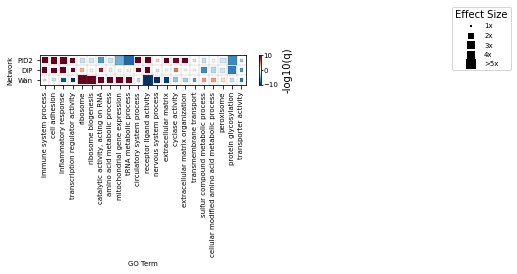

In [17]:
_ = go_plot_wrapper(gsea_example_results, example_network_names, sig_th=0.01, direction='under', cluster_on='P-value', 
                    correction='fdr', log_transform=True, marker='s')

## Fig 2D Full GSEA results

Load data from supplemental table 2 and plot the results for any terms with a significant under-enrichment in any network containing fewer than 10,000 nodes.  
**Note:** resulting plot clustering may not exactly match the published figure.

In [18]:
full_gsea = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/TableS2.txt'), sep='\t')
full_gsea = full_gsea.rename(columns={"GO Branch": 'branch', 'Observed/Expected':'OE', 'Term name':'Name'})
# use the reverse of the network names dictionary to map the network names to the original names
full_gsea['node_set'] = full_gsea['Network'].map({v:k for k,v in network_names.items()}) 

In [19]:
networks_10k = ['bind.v8', 'dip.PC', 'havugimana', 'hein', 'hi.union', 'hprd', 'mint', 'phosphosite', 'pid2', 'pips', 'preppi',
       'proper_all', 'proteomehd', 'ptmcode2', 'reactome.v86', 'signor', 'spike', 'wan', 'youn']


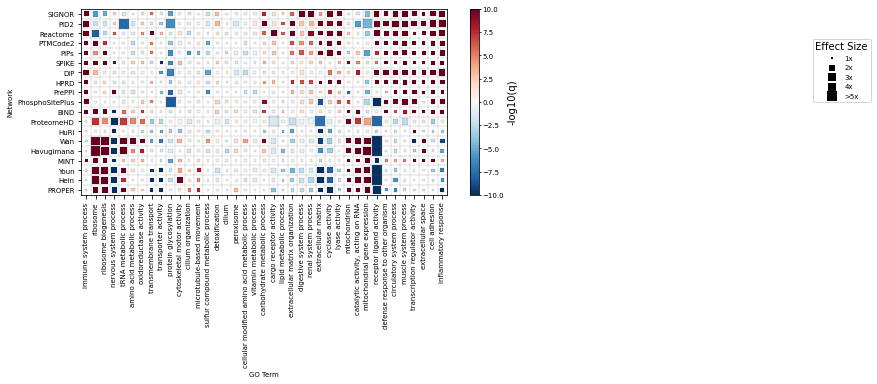

In [20]:
_ = go_plot_wrapper(full_gsea, network_names, network_set=networks_10k, sig_th=0.01, direction='under', cluster_on='P-value', correction='fdr', log_transform=True, marker='s')

## Example Interaction Analysis

Load the edge statistics from 1_Statistics_and_Representation.ipynb

In [21]:
with open(os.path.join(gitdir, "Data/example_outputs/edge_counts.pkl"), "rb") as f:
    edge_counts = pickle.load(f)
with open(os.path.join(gitdir, "Data/example_outputs/node_mapping.pkl"), "rb") as f:
    node_mapping = pickle.load(f)
    

Process the GO associations

In [22]:
use_terms = list(gsea_example_results.Term.unique())   
slim_associations = {}
for term in go_branches.keys():
    for go_term in go_branches[term]:
        slim_associations[go_term] = go_data.get_associated_genes(go_term)
term_sizes = {term: len(slim_associations[term]) for term in use_terms}

In [23]:
go_totals = np.zeros((len(use_terms), len(use_terms)))
for i, t1 in enumerate(use_terms):
    for j, t2 in enumerate(use_terms):
        if i == j:
            go_totals[i,j] = term_sizes[t1]*(term_sizes[t1]-1)/2
        else:
            s = set(slim_associations[t1]).union(set(slim_associations[t2]))
            go_totals[i,j] = len(s) * (len(s)-1)/2

go_totals_df= pd.DataFrame(go_totals, index=use_terms, columns=use_terms)

In [24]:
mapped_go_dict = defaultdict(list)
for go_term in slim_associations:
    if go_term in use_terms:
        for gene in slim_associations[go_term]:
            if gene in node_mapping:
                mapped_go_dict[node_mapping[gene]].append(go_term)

In [25]:
# Note that running this cell will take ~45 minutes
go_counts = np.zeros((len(use_terms), len(use_terms)))
for edge in tqdm(edge_counts):
    e1_go = mapped_go_dict[edge[0]]
    e2_go = mapped_go_dict[edge[1]]
    if len(e1_go) == 0 or len(e2_go) == 0:
        continue
    shared_terms = set(e1_go).intersection(set(e2_go))
    for term in shared_terms:
        go_counts[use_terms.index(term), use_terms.index(term)] += 1
    for go1 in e1_go:
        for go2 in e2_go:
            if go1 != go2:
                if (go1 not in e2_go) or (go2 not in e1_go):
                    go_counts[use_terms.index(go1), use_terms.index(go2)] += 1
                    go_counts[use_terms.index(go2), use_terms.index(go1)] += 1
                else:
                    go_counts[use_terms.index(go1), use_terms.index(go2)] += 1

100%|██████████| 57646/57646 [00:15<00:00, 3622.95it/s]


In [26]:
cg = sns.clustermap(go_counts/go_totals)
order = cg.dendrogram_col.reordered_ind
plt.close()

In [27]:
plot_go_counts = (go_counts/go_totals)[order, :][:, order]
for i in range(len(plot_go_counts)):
    for j in range(i+1,len(plot_go_counts)):
        plot_go_counts[j,i] = 0

In [28]:
term_order = pd.DataFrame({'term':[use_terms[i] for i in order]})
term_order = term_order.merge(gsea_example_results.loc[:, ('Term', 'Name')].drop_duplicates(), left_on='term', right_on='Term', how='left')

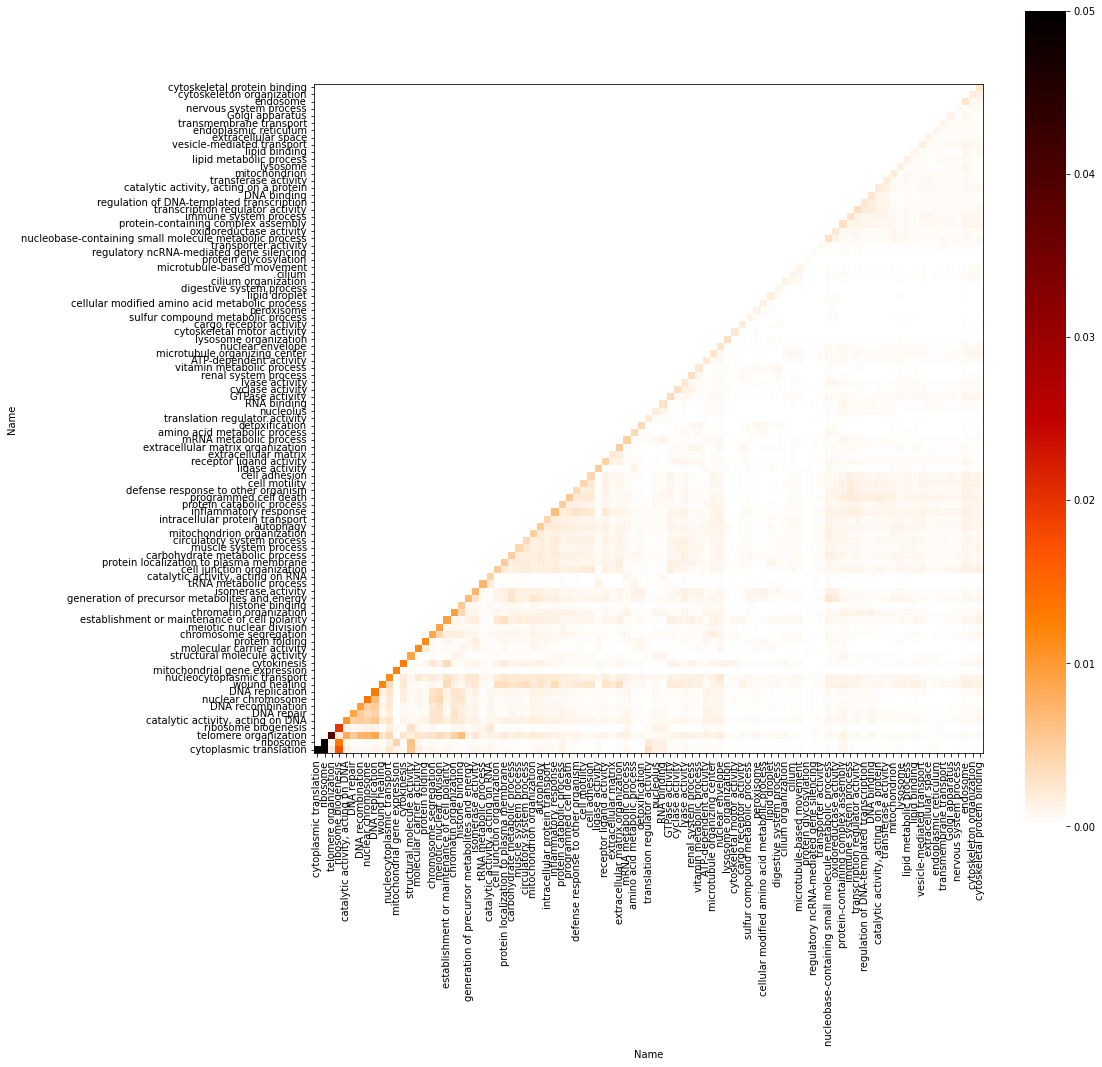

In [29]:
_ = plt.figure(figsize=(15,15))
ax= plt.gca()
sns.heatmap(pd.DataFrame(plot_go_counts, index=term_order['Name'], columns=term_order['Name']), cmap='gist_heat_r', square=True, vmin=0, vmax=0.05,xticklabels=True, yticklabels=True, ax=ax)

ax.invert_yaxis()
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.savefig(figdir+"Fig2I_GO_Interaction_heatmap.jpg", dpi=400, bbox_inches='tight')

## Fig 2G - GO Interaction Density

In [30]:
go_bin_data = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/Fig2I_go_bin_data.csv'), index_col=0)

In [31]:
cg = sns.clustermap(np.array(go_bin_data))
order = cg.dendrogram_col.reordered_ind
plt.close()

In [32]:
plot_go_counts = np.array(go_bin_data)[order, :][:, order]
for i in range(len(plot_go_counts)):
    for j in range(i+1,len(plot_go_counts)):
        plot_go_counts[j,i] = 0

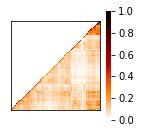

In [33]:
_ = plt.figure(figsize=(2,2))
ax= plt.gca()
sns.heatmap(plot_go_counts, cmap='gist_heat_r', square=True, vmin=0, vmax=1,xticklabels=False, yticklabels=False)
ax = plt.gca()
ax.invert_yaxis()
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)

## SFig4C-F - Gene function prediction

For example analysis see `StateOfTheInteractomes_Notebooks/Supplemental_Code/EGAD_README.md`

In [48]:
## Load the gene function prediction results
func_data = pd.read_csv(os.path.join(gitdir, 'StateOfTheInteractomes_Notebooks/Data/FigS4C_F_gene_function_prediction_results.tsv'), sep='\t', index_col=0)

In [49]:
func_data.head()

,Term,MeanAUC,avg_node_degree,degree_null_auc,auc_multifunc,Network,Source,Stat,Branch,Name,Type
0,GO:0008038,0.002613,95.545455,0.002086,NaN,comppi_interactions,GO_min10_max250_cv5,PR,BP,ComPPI,Composite
1,GO:1905145,0.007613,44.500000,0.001507,NaN,comppi_interactions,GO_min10_max250_cv5,PR,BP,ComPPI,Composite
2,GO:0097094,0.003445,23.222222,0.000869,NaN,comppi_interactions,GO_min10_max250_cv5,PR,BP,ComPPI,Composite
3,GO:0098780,0.002924,153.142857,0.000985,NaN,comppi_interactions,GO_min10_max250_cv5,PR,BP,ComPPI,Composite
4,GO:0051931,0.003470,23.411765,0.001623,NaN,comppi_interactions,GO_min10_max250_cv5,PR,BP,ComPPI,Composite


In [50]:
import statsmodels.stats.api as sms


def plot_scatter_with_error(data, stat, branch=None, y='MeanAUC', x='degree_null_auc', ax=None, hue_var='Network', annotate=False):
    if branch is not None:
        plot_data = data[data.Branch==branch]
    else:
        plot_data = data.copy()
    group_vars = ['Name', 'Stat', 'Type']
    if hue_var not in group_vars:
        group_vars.append(hue_var)
    mean_x_ci = plot_data.groupby(group_vars)[x].apply(lambda z: sms.DescrStatsW(z).tconfint_mean()).reset_index()
    mean_x_ci[['x_low', 'x_high']] = mean_x_ci[x].apply(pd.Series)
    mean_y_ci = plot_data.groupby(group_vars)[y].apply(lambda z: sms.DescrStatsW(z).tconfint_mean()).reset_index()
    mean_y_ci[['y_low', 'y_high']] = mean_y_ci[y].apply(pd.Series)
    mean_x_ci = mean_x_ci.drop(columns=x)
    mean_y_ci = mean_y_ci.drop(columns=y)
    ci_df = mean_x_ci.merge(mean_y_ci, on=group_vars)
    mean_data = plot_data.groupby(group_vars).mean().reset_index()
    combo_data = mean_data.merge(ci_df, on=group_vars)
    if ax is None:
        if annotate:
            _ = plt.figure(figsize=(15,15))
        else:
            _ = plt.figure(figsize=(5,5))
        ax = plt.gca()
    scatter_data = combo_data[combo_data.Stat==stat]

    
    ax.errorbar(x=scatter_data[x], y=scatter_data[y], xerr=[scatter_data[x]-scatter_data.x_low, scatter_data.x_high-scatter_data[x]], 
                yerr=[scatter_data[y]-scatter_data.y_low, scatter_data.y_high-scatter_data[y]], fmt='none', capsize=0, elinewidth=0.25,
                color='black', alpha=0.5)
    sns.scatterplot(data=scatter_data, hue=hue_var, x=x, y=y, legend=False, zorder=100, ax=ax,palette=['#ffa500', '#73c7e7', '#44cf6c'], 
                    hue_order=['Experimental', 'Composite', 'Curated'], s=20, edgecolor='black', linewidth=0.25)
    # plot 45 degree line
    lims = [0, 1]
    ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0, linewidth=0.25)
    if annotate:
        for i, row in scatter_data.iterrows():
            ax.text(row[x], row[y], row['Name'], fontsize=7)
    ax.set_xlabel('Mean Null AUROC')
    ax.set_ylabel('Mean AUROC')
    return scatter_data


def plot_branch_scatters_with_error(data, stat, annotate=False, usecol='MeanAUC'):
    plot_data = data[data.Stat == stat]
    
    # Calculate means for each branch
    branch_means = plot_data.groupby(['Name', 'Type', 'Branch']).mean().reset_index()
    branch_data = branch_means.pivot(index=['Name', 'Type'], columns='Branch', values='MeanAUC').reset_index()
    null_data = branch_means.pivot(index=['Name', 'Type'], columns='Branch', values='degree_null_auc').reset_index()

    if annotate:
        _, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(20, 9), sharey=False)
    else:
        _, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(6.5, 2), sharey=False)
    
    for i, (ax, x_branch, y_branch) in enumerate(zip([ax1, ax2, ax3], ['BP', 'BP', 'MF'], ['CC', 'MF', 'CC'])):
        
        x_data = plot_data[plot_data.Branch == x_branch]
        y_data = plot_data[plot_data.Branch == y_branch]
        ci_x = x_data.groupby(['Name', 'Type', 'Branch'])[usecol].apply(lambda z: sms.DescrStatsW(z).tconfint_mean()).reset_index()
        ci_x[['x_low', 'x_high']] = ci_x[usecol].apply(pd.Series)
        ci_y = y_data.groupby(['Name', 'Type', 'Branch'])[usecol].apply(lambda z: sms.DescrStatsW(z).tconfint_mean()).reset_index()
        ci_y[['y_low', 'y_high']] = ci_y[usecol].apply(pd.Series)
        mean_x_ci = ci_x.drop(columns=usecol)
        mean_y_ci = ci_y.drop(columns=usecol)
        ci_df = mean_x_ci.merge(mean_y_ci, on=['Name', 'Type'])
        combo_data = branch_data.merge(ci_df, on=['Name', 'Type'])
        ax.errorbar(x=combo_data[x_branch], y=combo_data[y_branch], xerr=[combo_data[x_branch]-combo_data.x_low, combo_data.x_high-combo_data[x_branch]], 
                yerr=[combo_data[y_branch]-combo_data.y_low, combo_data.y_high-branch_data[y_branch]], fmt='none', capsize=0, elinewidth=0.25,
                color='black', alpha=0.5, zorder=0)
        sns.scatterplot(data=branch_data, x=x_branch, y=y_branch, hue='Type', s=20, ax=ax, legend=False, edgecolor='black', linewidth=0.25,
                        palette=['#ffa500', '#73c7e7', '#44cf6c'], hue_order=['Experimental', 'Composite', 'Curated'], zorder=10)

        # Add error bars from the calculated confidence intervals for branch data

        
        ax.plot([0, 1], [0, 1], 'k--', alpha=0.75, zorder=0, linewidth=0.25)
        if stat == 'AUROC':
            ax.set_xlim(0.4, 0.95)
            ax.set_ylim(0.4, 0.95)
            ylim = 0.95
        elif (stat == 'PR') and (usecol == 'MeanAUC'):
            ax.set_xlim(0, 0.125)
            ax.set_ylim(0, 0.175)
            ax.set_xticks([0, 0.05, 0.1])
            ax.set_yticks([0, 0.05, 0.1, 0.15])
            ylim = 0.15
        else:
            ylim=1

        ax.vlines(null_data[x_branch].mean(), 0, 1, color='purple', alpha=0.5, linestyle='--', linewidth=0.5)
        ax.hlines(null_data[y_branch].mean(), 0, 1, color='purple', alpha=0.5, linestyle='--', linewidth=0.5)
        ax.set_xlabel(f'Mean {stat} ({x_branch})')
        ax.set_ylabel(f'Mean {stat} ({y_branch})')

        ax.annotate(f'Mean Null {stat} ({x_branch})', (null_data[x_branch].mean(), ylim * 0.99), color='purple', fontsize=7, ha='left', va='top', rotation=90)
        ax.annotate(f'Mean Null {stat} ({y_branch})', (ylim * 0.99, null_data[y_branch].mean()), color='purple', fontsize=7, ha='right', va='bottom')
        
        # Annotate points if requested
        if annotate:
            for j, txt in enumerate(branch_data['Name']):
                ax.annotate(txt, (branch_data[x_branch].iloc[j], branch_data[y_branch].iloc[j]), fontsize=5)
    
    # Show correlation matrix
    print(branch_data.corr())


### FigureS4C

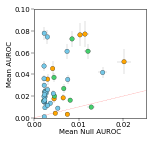

In [57]:
_, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(2,2), sharey=True)
sc_data = plot_scatter_with_error(func_data, stat='PR', ax=ax1, hue_var='Type', annotate=False)
ax1.set_xlim(0, 0.025)
ax1.set_ylim(0, 0.10)
ax1.set_xticks([0, 0.01, 0.02])
plt.savefig(os.path.join(figdir, 'FigS4C_EGAD_overall_scatter.svg'), dpi=300, bbox_inches='tight')

### FigureS4D-F

Branch        BP        CC        MF
Branch                              
BP      1.000000  0.933776  0.908624
CC      0.933776  1.000000  0.840033
MF      0.908624  0.840033  1.000000


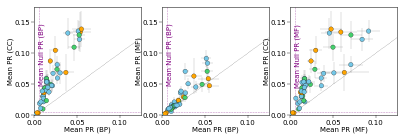

In [58]:
plot_branch_scatters_with_error(func_data, 'PR')
plt.savefig(os.path.join(figdir, 'EGAD_PR_branch_scatters.svg'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figdir, 'EGAD_PR_branch_scatters.jpg'), dpi=300, bbox_inches='tight')